In [183]:
import pandas as pd
import numpy as np
import datetime 
import re
from urlextract import URLExtract
import spacy
import time
import pickle
import matplotlib.pyplot as plt

In [184]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [185]:
extractor = URLExtract()
# remove all urls from posts
def replace_urls(x):
    urls = extractor.find_urls(x)
    if urls:
        x_new = replace_urls(x.replace(urls[0],''))
        return x_new
    else:
        return x

In [186]:
df_full = pd.read_csv('data/anxiety_full2.csv', low_memory=False)
# df_full = pd.read_csv('data/depression_full2.csv', low_memory=False)

df_full.dropna(subset=['selftext'], inplace=True)
df_full.dropna(subset=['title'], inplace=True)

In [187]:
df_full.selftext.isna().sum()

0

In [188]:
a = df_full.groupby('id').size().sort_values(ascending=False).values
b = df_full.groupby('selftext').size().sort_values(ascending=False).values
b

array([37, 36, 36, ...,  1,  1,  1])

In [189]:
# df_full = df_orig[(df_orig['selftext'] != '[deleted]') & (df_orig['selftext'] != '[removed]')].copy()

df_full.drop_duplicates(subset=['selftext'], inplace=True)
df_full.drop_duplicates(subset=['id'], inplace=True)

In [190]:
df_full.groupby('selftext').size().sort_values(ascending=False).head(10)

selftext
����\n\nMy anxiety is always overwhelming at night, and I’d like to know if anyone has an evening routine that helps calm anxious thoughts and promote restful sleep. I’m aware of the common recommendations like taking a warm bath, cutting out caffeine, etc. \n\nDoes anyone have another strategy (specific to calming racing thoughts and falling asleep) to recommend?\n\nSome background info: \n\nI’m a young breast cancer survivor.  I went through a radical double mastectomy, several major reconstructive surgeries, chemo,  and radiation. Thankfully, I am in remission and taking powerful meds to keep it that way. I’ve always struggled mightily with anxiety, but after such intense medical trauma, it seems to have worsened significantly. I have two young sons, a part-time job, and a husband who travels extensively for work. Needless to say, I am super busy during the day and my mind is occupied. \n\nHowever, it seems the moment things slow down in the evening and bedtime approaches, 

In [191]:
df_full['date'] = df_full.created_utc.apply(lambda x: pd.to_datetime(time.ctime(x)))

In [192]:
df_full['selftext'] = df_full.selftext.map(lambda x: re.sub("&amp;#x200B;",' ',str(x)))
df_full['selftext'] = df_full.selftext.map(lambda x: re.sub("&amp;nbsp;",' ',str(x)))
df_full['selftext'] = df_full.selftext.map(lambda x: re.sub("&amp;",' ',str(x)))
df_full['selftext'] = df_full.selftext.map(lambda x: re.sub("nbsp;",' ',str(x)))


df_full['selftext'] = df_full.selftext.map(lambda x: re.sub('\n',' ',str(x)))
df_full['selftext'] = df_full.selftext.map(lambda x: re.sub('  ',' ',str(x)))
df_full['selftext'] = df_full.selftext.map(lambda x: replace_urls(x))
# df_full['date'] = df_full.created_utc.apply(lambda x: pd.to_datetime(time.ctime(x)))

In [193]:
temp = df_full.groupby('title').size().sort_values(ascending=False)
df_full.drop_duplicates(subset=['selftext'], inplace=True)

In [194]:
df_full['text_title'] = df_full.title + ' ' + df_full.selftext
df_full['text_title'] = df_full['text_title'].apply(lambda x: str(x))
df_full['text_title'] = df_full.text_title.str.lower()

In [195]:
# df_non_null = df_full[(df_full.selftext != '[removed]')&(df_full.selftext != '[deleted]') & (df_full.selftext != 'nan')].copy()

In [196]:
df_full.text_title.value_counts().sort_values(ascending=False)

i feel frustrated and invisible at the same time i don’t even know why i feel this way. i made some awesome friends in college over the last month and i’m having a blast. sometimes i’m thinking “glad there’s no assholes like in high school”. other times i just get overwhelmed and awkward with everything, so then i do want things to be different but i don’t at the same time. i’m not used to being around so many nice people. i’ve spent years learning how to ignore and cope with mean or average people. sure i had a few good friends in high school, but it balanced out. now it’s just nice people and i’ve realised that i don’t know how to be around nice people all the time.  then i’m just not that social. sometimes i would just sit on my own at lunch, then feel really awkward when i’m invited over to sit with people on the same course. but after that no one notices my existence and then i don’t even talk while i’m there because i don’t know how or what to say. they are so kind, but i constan

In [197]:
# df_full.drop_duplicates(subset=['text_title'], inplace=True)

<AxesSubplot:xlabel='date,date'>

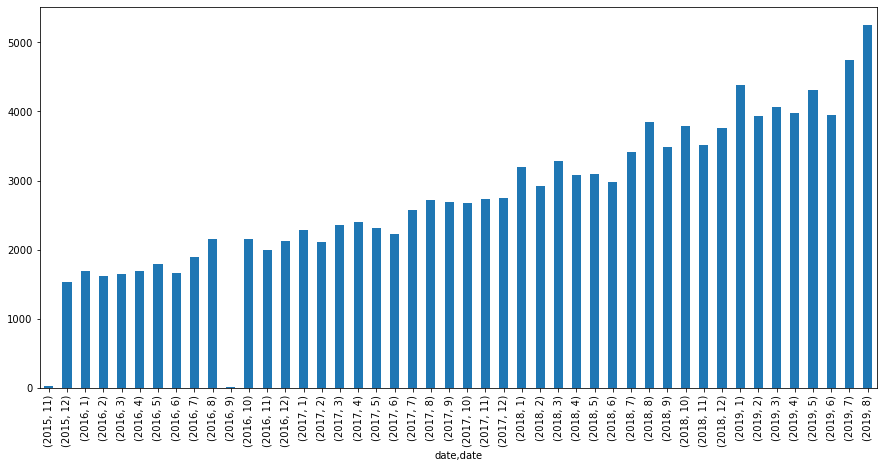

In [198]:
plt.figure(figsize=[15,7])
df_full.groupby([df_full["date"].dt.year, df_full["date"].dt.month]).size().plot(kind="bar")

In [199]:
nlp = spacy.load("en")

In [200]:
df_full.tail(5)

,created_utc,subreddit,author,domain,url,num_comments,score,ups,downs,title,...,is_self,from_id,permalink,name,author_flair_text,quarantine,link_flair_text,distinguished,date,text_title
140105,1496271608,Anxiety,kcapc213,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/6eio...,2,1,NaN,NaN,Do I have an anxiety disorder?,...,True,NaN,/r/Anxiety/comments/6eiorq/do_i_have_an_anxiet...,NaN,NaN,False,NaN,NaN,2017-05-31 18:00:08,"do i have an anxiety disorder? recently, i've ..."
140106,1493734262,Anxiety,mackstrat,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/68tc...,0,1,NaN,NaN,"A little bit of my life, parental issues, and ...",...,True,NaN,/r/Anxiety/comments/68tcf9/a_little_bit_of_my_...,NaN,NaN,False,NaN,NaN,2017-05-02 09:11:02,"a little bit of my life, parental issues, and ..."
140107,1494717413,Anxiety,Sportgirl234,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/6b0u...,10,97,NaN,NaN,Panic attack at the gym,...,True,NaN,/r/Anxiety/comments/6b0ubj/panic_attack_at_the...,NaN,NaN,False,NaN,NaN,2017-05-13 18:16:53,panic attack at the gym today my husband and i...
140111,1494131908,Anxiety,Whit3boy316,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/69pk...,1,4,NaN,NaN,6 year old with anxiety when sick - help,...,True,NaN,/r/Anxiety/comments/69pkrb/6_year_old_with_anx...,NaN,NaN,False,Needs A Hug/Support,NaN,2017-05-06 23:38:28,6 year old with anxiety when sick - help hello...
140112,1494188418,Anxiety,youtbuddcody,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/69ti...,3,2,NaN,NaN,What's riding in a train like compared to flying?,...,True,NaN,/r/Anxiety/comments/69tivp/whats_riding_in_a_t...,NaN,Panic Disorder,False,NaN,NaN,2017-05-07 15:20:18,what's riding in a train like compared to flyi...


In [201]:
df_clean = df_full.reset_index().drop(columns=['index'])
df_clean.tail(5)

,created_utc,subreddit,author,domain,url,num_comments,score,ups,downs,title,...,is_self,from_id,permalink,name,author_flair_text,quarantine,link_flair_text,distinguished,date,text_title
126719,1496271608,Anxiety,kcapc213,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/6eio...,2,1,NaN,NaN,Do I have an anxiety disorder?,...,True,NaN,/r/Anxiety/comments/6eiorq/do_i_have_an_anxiet...,NaN,NaN,False,NaN,NaN,2017-05-31 18:00:08,"do i have an anxiety disorder? recently, i've ..."
126720,1493734262,Anxiety,mackstrat,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/68tc...,0,1,NaN,NaN,"A little bit of my life, parental issues, and ...",...,True,NaN,/r/Anxiety/comments/68tcf9/a_little_bit_of_my_...,NaN,NaN,False,NaN,NaN,2017-05-02 09:11:02,"a little bit of my life, parental issues, and ..."
126721,1494717413,Anxiety,Sportgirl234,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/6b0u...,10,97,NaN,NaN,Panic attack at the gym,...,True,NaN,/r/Anxiety/comments/6b0ubj/panic_attack_at_the...,NaN,NaN,False,NaN,NaN,2017-05-13 18:16:53,panic attack at the gym today my husband and i...
126722,1494131908,Anxiety,Whit3boy316,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/69pk...,1,4,NaN,NaN,6 year old with anxiety when sick - help,...,True,NaN,/r/Anxiety/comments/69pkrb/6_year_old_with_anx...,NaN,NaN,False,Needs A Hug/Support,NaN,2017-05-06 23:38:28,6 year old with anxiety when sick - help hello...
126723,1494188418,Anxiety,youtbuddcody,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/69ti...,3,2,NaN,NaN,What's riding in a train like compared to flying?,...,True,NaN,/r/Anxiety/comments/69tivp/whats_riding_in_a_t...,NaN,Panic Disorder,False,NaN,NaN,2017-05-07 15:20:18,what's riding in a train like compared to flyi...


In [202]:
df_clean[df_clean.text_title.str.contains('anxious')]

,created_utc,subreddit,author,domain,url,num_comments,score,ups,downs,title,...,is_self,from_id,permalink,name,author_flair_text,quarantine,link_flair_text,distinguished,date,text_title
5,1451094315,Anxiety,pitykitty,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/3y8m...,1,2,2.0,0.0,Anxiety and Christmas,...,True,NaN,/r/Anxiety/comments/3y8mrh/anxiety_and_christmas/,t3_3y8mrh,GAD OCD Social Anxiety,False,NaN,NaN,2015-12-25 19:45:15,anxiety and christmas i was so anxious for chr...
8,1449453320,Anxiety,SugarSpellItOut24,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/3vqh...,0,1,1.0,0.0,Anxiety attacks or something else?,...,True,NaN,/r/Anxiety/comments/3vqh4m/anxiety_attacks_or_...,t3_3vqh4m,NaN,False,DAE Questions,NaN,2015-12-06 19:55:20,anxiety attacks or something else? sometimes w...
9,1449370473,Anxiety,HeyItsMezz,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/3vm8...,2,2,2.0,0.0,Anyone else experience worsened anxiety during...,...,True,NaN,/r/Anxiety/comments/3vm8bh/anyone_else_experie...,t3_3vm8bh,NaN,False,NaN,NaN,2015-12-05 20:54:33,anyone else experience worsened anxiety during...
10,1449976209,Anxiety,blackfacehobbyist,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/3wlm...,8,2,2.0,0.0,Anyone taken Effexor? I'm a week in and wonder...,...,True,NaN,/r/Anxiety/comments/3wlmzm/anyone_taken_effexo...,t3_3wlmzm,NaN,False,Medication,NaN,2015-12-12 21:10:09,anyone taken effexor? i'm a week in and wonder...
15,1449294058,Anxiety,pinkmagedon,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/3vie...,0,2,2.0,0.0,I hate my job. How do you guys cope?,...,True,NaN,/r/Anxiety/comments/3vieyj/i_hate_my_job_how_d...,t3_3vieyj,NaN,False,Work/Search,NaN,2015-12-04 23:40:58,i hate my job. how do you guys cope? i've been...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126704,1496162886,Anxiety,SUHDUDESUH,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/6e8j...,4,6,NaN,NaN,Job suggestions for an anxious person,...,True,NaN,/r/Anxiety/comments/6e8j2b/job_suggestions_for...,NaN,NaN,False,Work/Search,NaN,2017-05-30 11:48:06,job suggestions for an anxious person hello. i...
126706,1494229683,Anxiety,thatnoblekid,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/69wq...,0,1,NaN,NaN,First time posting but I'm unable to sleep and...,...,True,NaN,/r/Anxiety/comments/69wq8j/first_time_posting_...,NaN,NaN,False,NaN,NaN,2017-05-08 02:48:03,first time posting but i'm unable to sleep and...
126709,1495249785,Anxiety,subcore,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/6c88...,9,5,NaN,NaN,I'm 18. Anxiety or Brain Tumor?,...,True,NaN,/r/Anxiety/comments/6c8824/im_18_anxiety_or_br...,NaN,NaN,False,NaN,NaN,2017-05-19 22:09:45,i'm 18. anxiety or brain tumor? yesterday i wa...
126714,1494549767,Anxiety,doublekidsnoincome,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/6ao6...,10,1,NaN,NaN,Financial Stress &amp; Anxiety,...,True,NaN,/r/Anxiety/comments/6ao6j0/financial_stress_an...,NaN,NaN,False,NaN,NaN,2017-05-11 19:42:47,financial stress &amp; anxiety my biggest stre...


In [203]:
# df_clean.to_csv('data/depression_temp_clean.csv')

In [204]:
from spacy.lang.en.stop_words import STOP_WORDS

def process_text(nlp, text, pos_list, lemma=False):

    text_full = [] 
    for doc in nlp.pipe(text, disable=['parser', 'ner', 'tagger']):
        # if part of speech list isnt empty return matches for pos
        if pos_list:
            tokens = [(ent.pos_) for ent in doc if not ent.is_stop and not ent.is_punct and ent.pos_ in pos_list]
            cleaned_text = " ".join(tokens)
            text_full.append(cleaned_text)
        elif lemma == True:
            tokens = [(ent.lemma_) for ent in doc if not ent.is_stop and not ent.is_punct]
            cleaned_text = " ".join(tokens)
            text_full.append(cleaned_text)
        else:
            tokens = [(ent.text) for ent in doc if not ent.is_stop and not ent.is_punct]
            cleaned_text = " ".join(tokens)
            text_full.append(cleaned_text)
            
    return text_full

corp = df_clean.text_title
processed_text = process_text(nlp, corp, pos_list=[], lemma=False)
len(processed_text)

126724

In [268]:
anxiety_stop = ['feel','anxiety'
 'want',
 'myself',
 'people', 'feelings', 'feeling', 'not', 'fuck',
 'fucking','fucks', 'day', 'days', 'love', 'hate', 'try', 'talk', 'know', 'life','today', 'time', 'know'
'life', 'things', 'time', 'think', 'want', 'thoughts', 'wanna', 'felt', 'kinda', 'let'
'going', 'way', 'bad', 'good', 'years', 'got', 
'thought', 'thing', 'lot', 'right', 'better', 'thinking', 'mind',
'getting', 'away', 'stop', 'trying', 'long', 'said', 'started',
'person', 'hard', 'past', 'head', 'makes', 'little', 'having',
'point', 'sure', 'told', 'ago', 'weeks', 'months', 'stuff', 'find', 'times', 'able', 'maybe', 'bit', 'etc',
'happened', 'went', 'tomorrow', 'taking', 'hour', 'fine',
'guys', 'start', 'idk', 'going', 'new', 'making', 'lot', 'minutes', 'happen', 'week', 'pass', 'year', 'gon', 'need',
'tips', 'happen', 'happens', 'gets', 'usually'] + ['helps', 'help', 'helped', 'nervous', 'great', 'place', 'tell',
                                                   'advice', 'like', 'aaaand', 'aaah', 'anxious']

In [269]:
depression_stop = ['feel',
'want',
'myself',
'people', 'feelings', 'feeling', 'not', 'fuck',
'fucking','fucks', 'day', 'days', 'love', 'hate', 'try', 'talk', 'know', 'life',
'fuck', 'mental', 'shit', 'thing', 'things', 'wanna', 'way', 'think', 'anymore', 'having', 'group',
'happy', 'today', 'time','thanks','etc','better','year','years','lot','kinda', 'felt','going',
'wish', 'good','bad','person', 'die','told', 'care', 'cares', 'got', 'okay', 'end', 'need', 'help',
'aaa', 'aaaaaand', 'aaaaand', 'aaaand', 'aaand', 'aand', 'aas',
'let','happen', 'happened', 'happens', 'think','word','kinda','say', 'month','months','help', 'guy', 'ago', 'met', 'living',
'aaa', 'aaaaaand', 'aaaaand', 'aaaand', 'aaand', 'aand', 'aas', 'hard', 'long', 'said',
'have', 'live', 'lose', 'start', 'sure', 'able', 'maybe', 'find', 'times', 'new', 'make', 'get', 'getting', 'gets'
'feels', 'advice', 'makes', 'tell', 'telling', 'tells', 'away', 'idk', 'actually', 'thought', 'thoughts', 'taking'
'stopped', 'stop', 'say', 'saying', 'says', 'come', 'great', 'weeks', 'week', 'right', 'tomorrow', 'lately',
'work', 'tried', 'everyday', 'birthday', 'like',
'motivation'] + ['girlfriend', 'boyfriend', 'best', 'depression', 'anxiety', 'depressed', 'ask', 'asked', 'asking', 'went']
#  'depression'
#  'fucking',
#  'mental',
#  'hate',
#  'health',
#  'life',
#  'need',
#  'anxiety',
#  'talk',
#  'anymore',
#  'die',
# #  'friends',
#  'fuck',
#  'feeling',
#  'time',
#  'shit',
# #  'tired',
#  'happy',
#  'better',
#  'things',
#  'going',
#  'bad',
#  'way',
#  'care',
#  'good',
#  'wish',
#  'person',
#  'sad',
#  'day',
#  'makes',
#  'years',
#  'right',
#  'tell',
#  'self',
#  'love',
#  'worse',
#  'try',
#  'thoughts',
#  'live',
#  'stop',
#  'feel',
#  'help',
#  'nan',
#  'people',
#  'fucking',
#  'hate',
#  'myself',
#  'mental',
#  'health',
#  'depressed',
#  'fuck',
#  'shit',
#  'self',
#  'person',
#  'makes',
#  'better',
#  'wanna',
#  'sad',
#  'good',
#  'way',
#  'try',
#  'understand',
#  'wrong',
# #  'lonely',
#  'advice',
#   'lose',
#  'find',
#  'care',
#  'feelings',
#  'idk',
#  'emotions',
#  'bad',
#  'issues',
#  'talking',
#  'stupid',
#  'actually',
#  'ask',
#  'like',
#  'right',
#  'thoughts',
#  'life',
#  'things','best', 'bit', 'lot', 'great', 'says', 'getting', 'come', 'thing', 'little', 'today', 'started', 'maybe', 'feels', 'feel', 'feeling',
# "told", 'tomorrow', 'everyday', 'future', 'reason', 'pay', 'got', 'said', 'everyday', 'tomorrow', 'week', 'old', 'start', 'anxious', 'able', 'tried',
#    'features']+ ['think', 'thinking', 'happen', 'look', 'not', 'have', 'will', 'ill', 'sorry', 'alot', 'point', 'cuz', 'kinda', 'tell', 'exist', 'wait',
# 'post', 'have'] + ['let','happen','think','word','kinda','say','matt']





In [270]:
df_clean[df_clean.text_title.str.contains('friend')].shape[0]/df_clean.shape[0]

0.22973548814747008

In [271]:
vectorizer = TfidfVectorizer(
                             stop_words = anxiety_stop,
                             strip_accents='unicode',
                             min_df = 10,
                             ngram_range=(1, 1),
                             max_df = .5, 
                             token_pattern = r'\b[a-zA-Z]{3,}\b'
                             
)

# vectorizer = TfidfVectorizer(
#                              stop_words = depression_stop,
#                              strip_accents='unicode',
#                              min_df = 35,
# #                              ngram_range=(1, 1),
#                              ngram_range=(2, 2),

#                              max_df = .5, 
#                              token_pattern = r'\b[a-zA-Z]{3,}\b',
                             
# )

# vectorizer = TfidfVectorizer(
#                              stop_words = depression_stop,
#                              strip_accents='unicode',
#                              min_df = 28,
#                              ngram_range=(1, 1),
#                              max_df = .35, 
#                              token_pattern = r'\b[a-zA-Z]{3,}\b'
                             
# )

In [272]:
corpus = processed_text
doc_term = vectorizer.fit_transform(corpus).toarray()

In [273]:
df = pd.DataFrame(doc_term)
df.columns = vectorizer.get_feature_names()
df

,aback,abandon,abandoned,abandoning,abandonment,abate,abc,abd,abdomen,abdominal,...,zonked,zoo,zoom,zoomed,zooming,zopiclone,zumba,zyprexa,zyrtec,zzzquil
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
126720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
126721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
126722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [274]:
# 361698 rows × 17215 columns

In [275]:
def display_topics(model, feature_names, no_top_words, return_names=False, topic_names=None):
    topic_names = []
        
    if return_names:
        for ix, topic in enumerate(model.components_):
            topic =  "/".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
            topic_names.append(topic)
            
        return topic_names
    else:
        for ix, topic in enumerate(model.components_):

            if not topic_names or not topic_names[ix]:
                print("\nTopic ", ix)
            else:
                print("\nTopic: '",topic_names[ix],"'")
            print(", ".join([feature_names[i]
                            for i in topic.argsort()[:-no_top_words - 1:-1]]))

            print("\nTopic: ", ix)
            print([round(topic[i], 4) for i in topic.argsort()[:-no_top_words - 1:-1]])


In [276]:
nmf = NMF(16, alpha=.07, l1_ratio=.5, random_state=0, max_iter=300, init='nndsvd')
# nmf = NMF(11, alpha=.19, l1_ratio=.5, random_state=0, max_iter=500, init='nndsvd')
# nmf = NMF(12, alpha=.19, l1_ratio=.5, random_state=0, max_iter=10, init='nndsvd')

In [277]:
%%time
doc_topic = nmf.fit_transform(doc_term)

CPU times: user 44min 3s, sys: 32.4 s, total: 44min 36s
Wall time: 6min 12s


In [278]:
term_topic = nmf.components_

In [242]:

# with open('pickles/depression.pickle', 'wb') as file:
#     pickle.dump(doc_term, file, protocol=4)
#     pickle.dump(vectorizer.get_feature_names(), file, protocol=4)
#     pickle.dump(doc_topic, file, protocol=4)
#     pickle.dump(term_topic, file, protocol=4)
    
# with open('pickles/anxiety.pickle', 'wb') as file:
#     pickle.dump(doc_term, file, protocol=4)
#     pickle.dump(vectorizer.get_feature_names(), file, protocol=4)
#     pickle.dump(doc_topic, file, protocol=4)
#     pickle.dump(term_topic, file, protocol=4)

In [279]:
term_topic.shape

(16, 17794)

In [280]:
display_topics(model=nmf, feature_names=vectorizer.get_feature_names(), no_top_words=100)


Topic  0
fear, feels, wrong, actually, worry, brain, worse, self, depression, post, deal, constantly, control, look, normal, problem, kind, weird, let, end, pretty, mental, reason, understand, real, looking, body, read, shit, health, happy, world, afraid, talking, moment, come, recently, hope, probably, remember, sorry, completely, stress, worrying, wanted, anymore, issues, experience, problems, thanks, worried, reading, guess, different, stupid, sense, situation, believe, worst, care, mean, crazy, big, comes, thank, constant, lately, face, tried, saying, found, change, best, wish, literally, fact, hear, idea, cause, negative, okay, words, matter, similar, goes, sort, future, explain, issue, ocd, focus, small, example, ask, basically, dealing, calm, use, happening, question

Topic:  0
[1.759, 1.6273, 1.4837, 1.4814, 1.4779, 1.4764, 1.3811, 1.357, 1.3273, 1.3257, 1.3069, 1.2242, 1.191, 1.1854, 1.1762, 1.1737, 1.1648, 1.0848, 1.0763, 1.0688, 1.0584, 1.0527, 1.0362, 1.0034, 0.997, 0.9551

In [283]:
doc_topic2 = pd.DataFrame(doc_topic)
doc_topic2

# anxiety_cols = ['general', 'panic', 'occupational',
#                 'sleep', 'medication', 'heart/chest',
#                 'anxious/super/reason', 'school', 'work',
#                 'friends/hang/groups', 'driving', 'sick/eat/stomach',
#                 'scared/fear/die', 'social/media/situations']

anxiety_cols = display_topics(model=nmf,
                                 feature_names=vectorizer.get_feature_names(),
                                 no_top_words=2,
                                 return_names=True)

# depression_cols = ['general', 'depression/anxiety/diagnosed',
#                    'work/issues', 'tired/exhaused/complaints', 
#                    'social', 'depressed/unclear', 'school', 'sleep',
#                    'friend_drama', 'sad/emo', 'family', 'suicide',
#                    'therapy/medication', 'work/occupational']

# depression_cols = display_topics(model=nmf,
#                                  feature_names=vectorizer.get_feature_names(),
#                                  no_top_words=2,
#                                  return_names=True)

doc_topic2.columns = anxiety_cols
doc_topic2

,fear/feels,panic/attack,job/interview,sleep/night,medication/doctor,heart/chest,school/class,work/working,friends/friend,home/house,sick/eat,scared/fear,social/media,driving/car,relationship/boyfriend,therapy/therapist
0,0.003875,0.000000,0.006028,0.004594,0.000000,0.000468,0.00000,0.000000,0.005859,0.001958,0.001653,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.012741,0.000000,0.000000,0.001934,0.002142,0.000385,0.01533,0.000000,0.000000,0.004119,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.004704,0.000000,0.000000,0.011356,0.000000,0.002827,0.00000,0.000000,0.000000,0.000389,0.000000,0.002613,0.000000,0.000000,0.000000,0.000000
3,0.008541,0.002221,0.000000,0.001228,0.000000,0.000000,0.00000,0.003539,0.000000,0.004546,0.000000,0.010038,0.006657,0.000000,0.008038,0.000000
4,0.003803,0.000000,0.000000,0.000000,0.013978,0.000000,0.00000,0.000000,0.001122,0.003854,0.000000,0.000000,0.000111,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126719,0.011150,0.000168,0.000000,0.000000,0.000000,0.000000,0.00000,0.006868,0.000000,0.000000,0.003374,0.000000,0.007609,0.000000,0.000000,0.000750
126720,0.005397,0.001128,0.011306,0.000552,0.002277,0.000069,0.00325,0.001677,0.000494,0.031587,0.002910,0.000000,0.000000,0.000000,0.009610,0.000440
126721,0.002875,0.008811,0.000000,0.000000,0.000000,0.004888,0.00000,0.014942,0.000000,0.005819,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
126722,0.004291,0.000006,0.000000,0.000000,0.000824,0.000000,0.00000,0.004504,0.000000,0.001386,0.031474,0.005314,0.000000,0.000000,0.001703,0.000000


In [284]:
df_temp = df_clean.reset_index().drop(columns=['index'])
doc_topic_full = df_temp.join(doc_topic2)
# doc_topic_full.drop(columns=['point/feels'],inplace=True)
# doc_topic_full['max_topic'] = doc_topic_full[depression_cols[1::]].idxmax(axis=1)
doc_topic_full

doc_topic_full.to_csv('data/anxiety_topics.csv')

In [267]:
doc_topic_full.sort_values(by=['anxious/super'], ascending=False).selftext.values[101]

"I've been dealing with anxiety for years and right now I'm kinda in a bad moment. I go to sleep anxious and as soon as i wake up I get anxiety, without having to think something to get anxious for? Any tips on how to prevent this? "

In [484]:
# doc_topic_full.to_csv('data/depression_topics_test.csv')
topic = 'social/media/situations'
idx = 1027
print(doc_topic_full.sort_values(by=[topic], ascending=False)[['text_title'] + anxiety_cols[1::] + ['max_topic']].iloc[idx])
print(doc_topic_full.sort_values(by=[topic], ascending=False)['text_title'].iloc[idx])



text_title                 does anyone else feel like everything/everyone...
panic                                                                      0
occupational                                                     2.00934e-05
sleep                                                                      0
medication                                                                 0
heart/chest                                                                0
anxious/super/reason                                                       0
school                                                                     0
work                                                                       0
friends/hang/groups                                                        0
driving                                                                    0
sick/eat/stomach                                                           0
scared/fear/die                                                            0

In [260]:
df_clean[df_clean.selftext.str.contains('anxious')]

,created_utc,subreddit,author,domain,url,num_comments,score,ups,downs,title,...,is_self,from_id,permalink,name,author_flair_text,quarantine,link_flair_text,distinguished,date,text_title
5,1451094315,Anxiety,pitykitty,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/3y8m...,1,2,2.0,0.0,Anxiety and Christmas,...,True,NaN,/r/Anxiety/comments/3y8mrh/anxiety_and_christmas/,t3_3y8mrh,GAD OCD Social Anxiety,False,NaN,NaN,2015-12-25 19:45:15,anxiety and christmas i was so anxious for chr...
8,1449453320,Anxiety,SugarSpellItOut24,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/3vqh...,0,1,1.0,0.0,Anxiety attacks or something else?,...,True,NaN,/r/Anxiety/comments/3vqh4m/anxiety_attacks_or_...,t3_3vqh4m,NaN,False,DAE Questions,NaN,2015-12-06 19:55:20,anxiety attacks or something else? sometimes w...
9,1449370473,Anxiety,HeyItsMezz,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/3vm8...,2,2,2.0,0.0,Anyone else experience worsened anxiety during...,...,True,NaN,/r/Anxiety/comments/3vm8bh/anyone_else_experie...,t3_3vm8bh,NaN,False,NaN,NaN,2015-12-05 20:54:33,anyone else experience worsened anxiety during...
10,1449976209,Anxiety,blackfacehobbyist,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/3wlm...,8,2,2.0,0.0,Anyone taken Effexor? I'm a week in and wonder...,...,True,NaN,/r/Anxiety/comments/3wlmzm/anyone_taken_effexo...,t3_3wlmzm,NaN,False,Medication,NaN,2015-12-12 21:10:09,anyone taken effexor? i'm a week in and wonder...
15,1449294058,Anxiety,pinkmagedon,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/3vie...,0,2,2.0,0.0,I hate my job. How do you guys cope?,...,True,NaN,/r/Anxiety/comments/3vieyj/i_hate_my_job_how_d...,t3_3vieyj,NaN,False,Work/Search,NaN,2015-12-04 23:40:58,i hate my job. how do you guys cope? i've been...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126703,1495286537,Anxiety,jemma_swearsss,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/6cab...,1,2,NaN,NaN,Why am I suddenly getting anxiety every Day?,...,True,NaN,/r/Anxiety/comments/6cabeq/why_am_i_suddenly_g...,NaN,NaN,False,NaN,NaN,2017-05-20 08:22:17,why am i suddenly getting anxiety every day? h...
126706,1494229683,Anxiety,thatnoblekid,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/69wq...,0,1,NaN,NaN,First time posting but I'm unable to sleep and...,...,True,NaN,/r/Anxiety/comments/69wq8j/first_time_posting_...,NaN,NaN,False,NaN,NaN,2017-05-08 02:48:03,first time posting but i'm unable to sleep and...
126709,1495249785,Anxiety,subcore,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/6c88...,9,5,NaN,NaN,I'm 18. Anxiety or Brain Tumor?,...,True,NaN,/r/Anxiety/comments/6c8824/im_18_anxiety_or_br...,NaN,NaN,False,NaN,NaN,2017-05-19 22:09:45,i'm 18. anxiety or brain tumor? yesterday i wa...
126714,1494549767,Anxiety,doublekidsnoincome,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/6ao6...,10,1,NaN,NaN,Financial Stress &amp; Anxiety,...,True,NaN,/r/Anxiety/comments/6ao6j0/financial_stress_an...,NaN,NaN,False,NaN,NaN,2017-05-11 19:42:47,financial stress &amp; anxiety my biggest stre...


In [39]:
# doc_topic_full.to_csv('anxiety_topics_final.csv')

In [362]:
# doc_topic_full[doc_topic_full.max_topic == 'kill/self/reason'][['text_title'] + depression_cols[1::] + ['max_topic']].values[1121]



<AxesSubplot:>

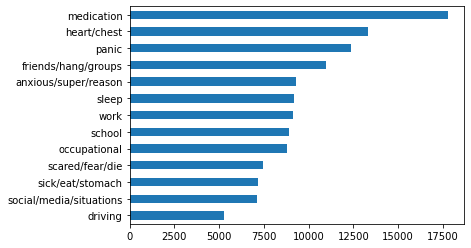

In [486]:
# doc_topic_full.groupby('max_topic').size().sort_values(ascending=True).plot.barh()
doc_topic_full.max_topic.value_counts().sort_values(ascending=True).plot.barh()

In [402]:
doc_topic_full.to_csv('depression_topics_final.csv')

In [ ]:
doc_topic_full[['text_title']+ cols +['max_topic']].sort_values(by=['family'], ascending=False).values[500]


In [ ]:
doc_topic_full.max_topic.value_counts(normalize=True).sort_values().plot.barh()

In [ ]:
plt.figure(figsize=[15,9])

df_temp = doc_topic_full.groupby(doc_topic_full.date.dt.date)['max_topic'].value_counts().to_frame()
df_temp.columns = ['max topic count']
df_temp = df_temp.reset_index()
a = df_temp[df_temp['max_topic'] == 'home/house'].date
b = df_temp[df_temp['max_topic'] == 'home/house']['max topic count']
# plt.bar(a, b)

x = df_temp[df_temp.max_topic == 'social'].date 
y = df_temp[df_temp.max_topic == 'social']['max topic count'].rolling(10).sum()
x2 = df_temp[df_temp.max_topic == 'home/house'].date 
y2 = df_temp[df_temp.max_topic == 'home/house']['max topic count'].rolling(10).sum()
plt.plot(x,y, label='social')
plt.plot(x2,y2, label='school')
plt.legend()

In [ ]:
# doc_topic = pd.DataFrame(doc_topic)
# doc_topic['post'] = df_full.text_title
# doc_topic.values[2]

In [ ]:
# nmf.components_

In [35]:
from corextopic import corextopic as ct
from corextopic import vis_topic as vt

In [37]:
df_clean


,created_utc,subreddit,author,domain,url,num_comments,score,ups,downs,title,...,is_self,from_id,permalink,name,author_flair_text,quarantine,link_flair_text,distinguished,date,text_title
0,1451002020,Anxiety,spwf,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/3y4s...,2,4,4.0,0.0,"My empathy bites me in the ass, on a frequent ...",...,True,NaN,/r/Anxiety/comments/3y4suk/my_empathy_bites_me...,t3_3y4suk,NaN,False,NaN,NaN,2015-12-24 18:07:00,"my empathy bites me in the ass, on a frequent ..."
1,1451448026,Anxiety,steve472,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/3yqo...,4,3,3.0,0.0,hey guys can you help me out? thanks,...,True,NaN,/r/Anxiety/comments/3yqouu/hey_guys_can_you_he...,t3_3yqouu,NaN,False,Needs A Hug/Support,NaN,2015-12-29 22:00:26,hey guys can you help me out? thanks hey guys ...
2,1451183146,Anxiety,cooperslink,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/3ycq...,5,3,3.0,0.0,This is probably common...,...,True,NaN,/r/Anxiety/comments/3ycqjv/this_is_probably_co...,t3_3ycqjv,NaN,False,NaN,NaN,2015-12-26 20:25:46,this is probably common... i always feel like ...
3,1450836919,Anxiety,[deleted],self.Anxiety,https://www.reddit.com/r/Anxiety/comments/3xwu...,0,2,2.0,0.0,My Boyfriend Is Afraid of Disasters Every Day,...,True,NaN,/r/Anxiety/comments/3xwuuf/my_boyfriend_is_afr...,t3_3xwuuf,NaN,False,Relationships,NaN,2015-12-22 20:15:19,my boyfriend is afraid of disasters every day ...
4,1450657537,Anxiety,ArcadeInvasion,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/3xn1...,6,10,10.0,0.0,What do you do to help with your anxiety?,...,True,NaN,/r/Anxiety/comments/3xn1yo/what_do_you_do_to_h...,t3_3xn1yo,NaN,False,Needs A Hug/Support,NaN,2015-12-20 18:25:37,what do you do to help with your anxiety? just...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126719,1496271608,Anxiety,kcapc213,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/6eio...,2,1,NaN,NaN,Do I have an anxiety disorder?,...,True,NaN,/r/Anxiety/comments/6eiorq/do_i_have_an_anxiet...,NaN,NaN,False,NaN,NaN,2017-05-31 18:00:08,"do i have an anxiety disorder? recently, i've ..."
126720,1493734262,Anxiety,mackstrat,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/68tc...,0,1,NaN,NaN,"A little bit of my life, parental issues, and ...",...,True,NaN,/r/Anxiety/comments/68tcf9/a_little_bit_of_my_...,NaN,NaN,False,NaN,NaN,2017-05-02 09:11:02,"a little bit of my life, parental issues, and ..."
126721,1494717413,Anxiety,Sportgirl234,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/6b0u...,10,97,NaN,NaN,Panic attack at the gym,...,True,NaN,/r/Anxiety/comments/6b0ubj/panic_attack_at_the...,NaN,NaN,False,NaN,NaN,2017-05-13 18:16:53,panic attack at the gym today my husband and i...
126722,1494131908,Anxiety,Whit3boy316,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/69pk...,1,4,NaN,NaN,6 year old with anxiety when sick - help,...,True,NaN,/r/Anxiety/comments/69pkrb/6_year_old_with_anx...,NaN,NaN,False,Needs A Hug/Support,NaN,2017-05-06 23:38:28,6 year old with anxiety when sick - help hello...


In [38]:
words = list(np.asarray(vectorizer.get_feature_names()))

In [51]:
anch_words = [['social', 'media'],
              ['scared', 'fear'],
              ['sick', 'eat'],
              ['driving', 'car'],
              ['school'],
              ['friends'], ['heart', 'chest']]



In [52]:
list(anch_words)

[['social', 'media'],
 ['scared', 'fear'],
 ['sick', 'eat'],
 ['driving', 'car'],
 ['school'],
 ['friends'],
 ['heart', 'chest']]

In [53]:
import scipy.sparse as ss
doc_term2 = ss.csr_matrix(doc_term)

In [56]:
anchored_topic_model = ct.Corex(n_hidden=8, seed=1, verbose=False)
anchored_topic_model.fit(doc_term2, words=words, anchors=anch_words, anchor_strength=3, docs=df_clean.text_title)




In [57]:
topics = anchored_topic_model.get_topics(n_words=50)
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))
    print()

0: irc,downloads,salutations,faq,wiki,newcomers,weblink,chatroom,qotw,greetings,protector,provocation,provoked,psychopathic,pyjamas,aaaand,props,quirk,raid,ramen,rarity,ratio,readily,qid,promiscuous,presses,profuse,phobias,phrasing,pig,pinpoint,pit,planing,plant,plucked,plunged,pointer,politician,poof,potato,practices,presently,rearrange,prioritizing,progressing,reassurances,recieving,receives,risking,risky

1: absolutley,psychologically,puppet,purchased,quadruple,qualifies,quasi,que,proximity,quiets,rack,racked,radically,rainbow,ramifications,ratings,raw,quoted,readjust,protest,promising,pipes,plane,playlists,pleasures,plummet,poked,postpartum,prone,practising,preceding,preferable,preoccupation,prepped,pricks,productively,prolong,practitioners,pilots,realisation,reasoned,restored,restricting,retaining,retiring,rewatching,rewire,risen,restart,rituals

2: absorbing,purchasing,pure,pursuits,pushups,quack,qualifying,quantity,quiting,pups,quo,ragged,rail,raising,rampage,ranged,raping,refoc